In [1]:
import scipy.io as sio
import torch
from spenpy.spen import spen

import matplotlib.pyplot as plt

class physical_model:
    def __init__(self, img_size=(96, 96)):
        self.InvA, self.AFinal = spen(acq_point=img_size).get_InvA()
    
    def __call__(self, x, phase_map=None):
        x = torch.matmul(self.AFinal * 1j, x)
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(1j * phase_map)
        return x
    
    def recons(self, x, phase_map=None):
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(-1j * phase_map)
        return torch.matmul(self.InvA, x)
    
    
def get_demo(data_root="/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim", 
             id="IXI050-Guys-0711-T1_idx0009.mat",
             if_phase_map=False):
    PM = physical_model()
    if(if_phase_map):
        phase_map = sio.loadmat(f"{data_root}/phase_map/{id}")
        phase_map = phase_map[next(reversed(phase_map.keys()))]
        phase_map = torch.tensor(phase_map, dtype=torch.complex64).unsqueeze(0)
    
    data = sio.loadmat(f"{data_root}/hr/{id}")
    data = data[next(reversed(data.keys()))]
    data = data / data.max()
    data = torch.tensor(data, dtype=torch.complex64).unsqueeze(0)
    

    if if_phase_map:
        lr = PM(data, phase_map=phase_map)  
        recons = PM.recons(lr, phase_map=phase_map)
    else:
        lr = PM(data)
        recons = PM.recons(lr)
    
    return data, lr, recons

In [2]:
data, lr, recons = get_demo(if_phase_map=1)

/tmp/ipykernel_3317903/2517882270.py:2: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  plt.imshow(torch.tensor(data[0].numpy(), dtype=torch.float32).numpy(), cmap='gray')


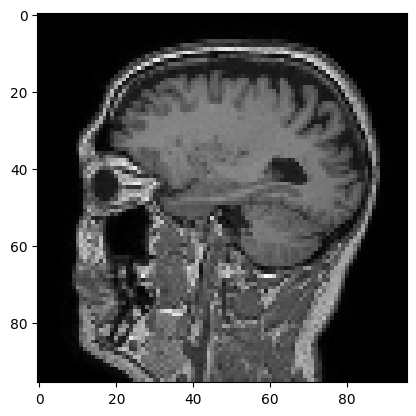

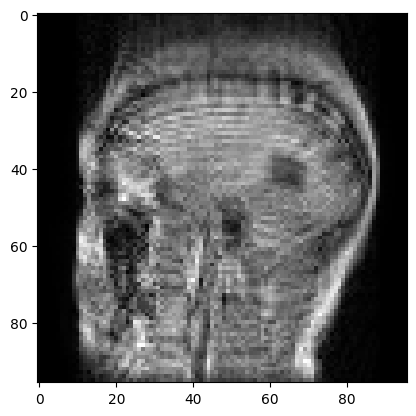

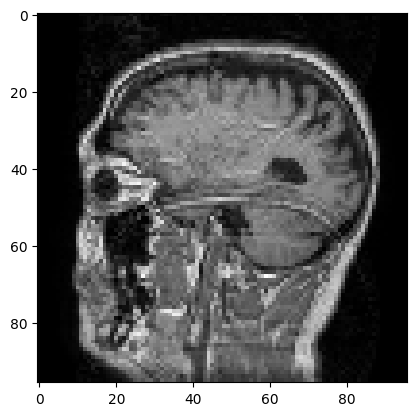

In [3]:
plt.figure()
plt.imshow(torch.tensor(data[0].numpy(), dtype=torch.float32).numpy(), cmap='gray')

plt.figure()
plt.imshow(lr[0].cpu().abs().numpy(), cmap='gray')

plt.figure()
plt.imshow(recons[0].cpu().abs().numpy(), cmap='gray')